# Import

In [1]:
#%matplotlib notebook
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack

# Reading files

In [2]:
# Rl = 90; N=256
# folder_in = "dt_003_T_25/"
# run_files=[30, 51, 79, 86, 85, 77, 89]

Rl = 240; N=128
folder_in = ""
run_files=[487, 493]
spec_component = "xx"

common_folder = "/home/gorbunov8a/Documents/MATLAB/data/corr/LES/"
correlation_type = "two_point_corr"
spec_type = "lin"

nb_of_runs = len(run_files)
for run_index in list(range(nb_of_runs)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
    if (run_files[run_index] < 1000) :
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
    else : 
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)
    if not('accumulated_data' in dir()) : 
        accumulated_data = file_data.copy()
    else : 
        accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
averaging_coef = 1.0/nb_of_runs
k = np.array(accumulated_data[0])*averaging_coef
nb_of_modes = np.array(accumulated_data[1])*averaging_coef

average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
for i in list(range(average_data.shape[0])) : 
    average_data[i, :] = np.array(accumulated_data[i+2])*averaging_coef
t = average_data[:,0]
correlation_mean = np.array(average_data[:,1:])

del average_data, file_data, accumulated_data

# Define parameters

In [3]:
# PARAMETERS
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L=2.65
    dissipation_rate=0.31e-04
    urms=np.sqrt(3*0.2282712E-02/2)
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025  
    L=2.65 
    dissipation_rate=2.24565e-06
elif (Rl == 240) :
    lmbda = 0.09986 
    eta = 0.003176  
    L = 1.5
    dissipation_rate = 0.00984
t0=dissipation_rate**(-1/3)*L**(2/3) #large scale eddy-turnover time
spatial_scales = np.array([L, lmbda, eta])
normalization_status = True
pi = np.pi

# Normalization

In [4]:
t_length=t.shape[0]
wavenumbers_length=k.shape[0]
if normalization_status :
#     k_norm_coef = L
#     t_norm_coef = 1.0/t0
#     t=t*t_norm_coef
#     k=k*k_norm_coef
#     spatial_scales = 1.0/k_norm_coef * spatial_scales
    
    normalization = (correlation_mean[0,:])**(-1)
else : 
    normalization = np.ones(wavenumbers_length)

wn_scales = 2.0*np.pi/spatial_scales

# Plotting params

In [5]:
kmin = 4
kmax = 16
nb_of_curves = 11
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
indices_of_k_to_plot.append(40)
print(indices_of_k_to_plot)

plt.rc('axes', labelsize=12)  
plt.rc('axes', titlesize=12)  
plt.rc('legend', fontsize=12)  

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 40]


# Spatial spectrum from C_2(t=0,k)

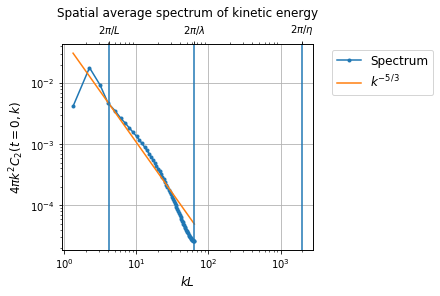

In [6]:
fig, ax = plt.subplots(constrained_layout=True)
kinetic_energy = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    coefficient = 4.0*np.pi*k[ik]*k[ik]
    kinetic_energy[ik] = correlation_mean[0,ik]*coefficient
ax.plot(k, kinetic_energy, '.-', label='Spectrum')
ax.plot(k, 5e-2*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$kL$', ylabel=r'$4\pi k^2 C_2(t=0,k)$', title='Spatial average spectrum of kinetic energy')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

for line in wn_scales : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(wn_scales); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

# Plot time correlation functions

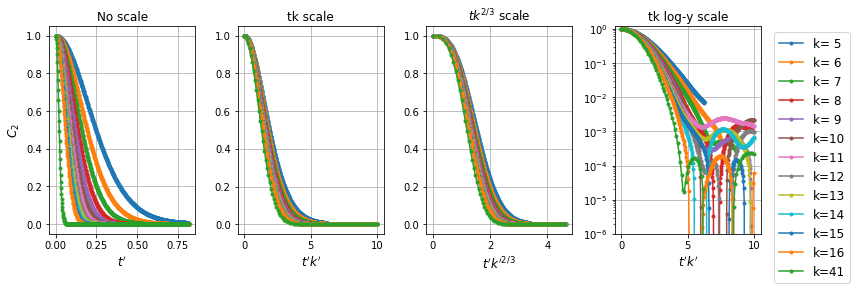

In [29]:
tk1 = 0.0
tk2 = 10.0

fig, (norm_scale, tk_scale, tk23_scale, log_scale) = plt.subplots(nrows=1, ncols=4,figsize=(12,4))
for ik in indices_of_k_to_plot :
    a = np.searchsorted(t/t0*k[ik]*L, tk1)
    b = np.searchsorted(t/t0*k[ik]*L, tk2)
    x = (t[a:b]/t0)*(k[ik]*L)
    norm_scale.plot(t/t0, correlation_mean[:,ik]*normalization[ik], '.-')
    tk_scale.plot(x, correlation_mean[a:b,ik]*normalization[ik], '.-')
    tk23_scale.plot(x**(2.0/3.0), correlation_mean[a:b,ik]*normalization[ik], '.-')
    log_scale.semilogy(x, correlation_mean[a:b,ik]*normalization[ik], '.-', label='k=%2.f' % (k[ik]))
norm_scale.set(title='No scale', ylabel=r'$C_2$', xlabel=r'$t^\prime$'); norm_scale.grid()
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$'); tk_scale.grid()
tk23_scale.set(title=r'$tk^{2/3}$ scale', xlabel=r'$t^\prime {k^\prime}^{2/3}$'); tk23_scale.grid()
log_scale.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$', ylim=[10e-7, 1.2]); log_scale.grid()
log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

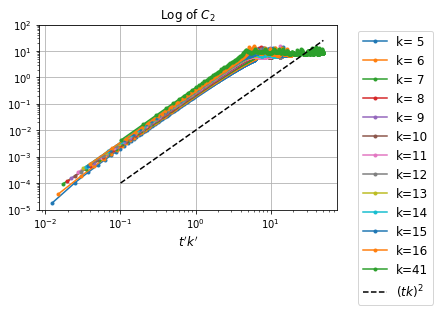

In [8]:
fig, ax = plt.subplots(constrained_layout=True)
for ik in indices_of_k_to_plot :
    ax.plot(t[1:]/t0*k[ik]*L, -(np.log(np.abs(correlation_mean[1:,ik]*normalization[ik]))), '.-', label='k=%2.f' % (k[ik]))
    #plt.plot(nu, 1.0/N * np.imag(yplot[:, ik]), label='k=%2.f' % k[ik])
#plt.xlim(-15, 15) 
ax.plot(t[1:]/t0*k[ik]*L, 10e-3*np.power(t[1:]/t0*k[ik]*L, 2.0), 'k--', label=r'$(tk)^2$')
ax.set(xscale='log', yscale='log', xlabel=r'$t^\prime k^\prime$',title=r'Log of $C_2$')
ax.set(ylim=[10e-6, 100])
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


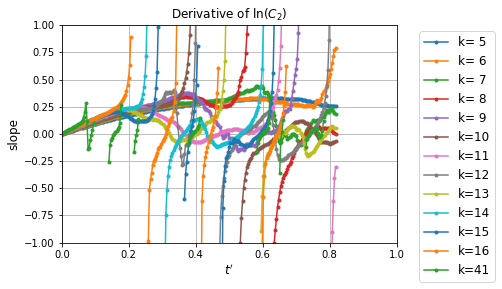

In [9]:
#derivative of ln(C_2)
for ik in indices_of_k_to_plot :
    resampling = 2
    x = t[::resampling]/t0
    f = -np.log(correlation_mean[::resampling,ik]*normalization[ik])
    deriv1 = np.gradient(f, x)
    np.place(deriv1, np.abs(deriv1/k[ik]**2.0)>2.0, np.nan)
    plt.plot(x, deriv1/k[ik]**2.0, '.-', label='k=%2.f' % k[ik])
# plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-',label=r'$\omega^{-1}$')
# plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-', label=r'$\omega^{-5/3}$')
plt.xlabel(r'$t^\prime$'), plt.ylabel('slope')
plt.title(r'Derivative of $\ln(C_2)$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('linear')
plt.xlim([0, 1.0])
plt.ylim([-1, 1])
plt.grid()
plt.show()

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


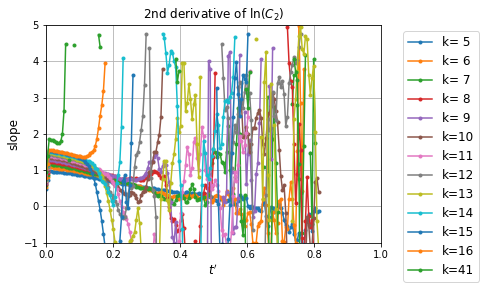

In [10]:
#2nd derivative of ln(C_2)
for ik in indices_of_k_to_plot :
    resampling = 3
    x = t[::resampling]/t0
    f = -np.log(correlation_mean[::resampling,ik]*normalization[ik])
    deriv1 = np.gradient(f, x)
    np.place(deriv1, np.abs(deriv1/k[ik]**2.0)>1.0, np.nan)
    deriv2 = np.gradient(deriv1/k[ik]**2.0, x)
    np.place(deriv2, np.abs(deriv2)>5, np.nan)
    plt.plot(x, deriv2, '.-', label='k=%2.f' % k[ik])
# plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-',label=r'$\omega^{-1}$')
# plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-', label=r'$\omega^{-5/3}$')
plt.xlabel(r'$t^\prime$'), plt.ylabel('slope')
plt.title(r'2nd derivative of $\ln(C_2)$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('linear')
plt.xlim([0, 1.0])
plt.ylim([-1, 5.0])
plt.grid()
plt.show()

# Integral decorrelation time

In [11]:
integral_decorrelation_time = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    integral_decorrelation_time[ik] = np.trapz(correlation_mean[:,ik]*normalization[ik], x=t)

In [12]:
#microscale_time 
microscale_time = np.zeros(shape=wavenumbers_length, dtype=float)

#second order right side finite difference scheme for the second derivative
deltaT = t[1] - t[0]
for ik in list(range(wavenumbers_length)) : 
    u = correlation_mean[:,ik]*normalization[ik]
    derivative = (2.0*u[0] - 5.0*u[1] + 4.0*u[2] - u[3])/(deltaT*deltaT)
    microscale_time[ik] = (-derivative)**(-0.5)

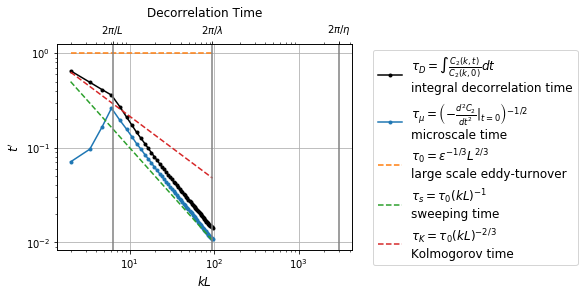

In [13]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,4))
ax.plot(k*L, integral_decorrelation_time/t0,  'k.-', label=r"$\tau_D = \int \frac{C_2(k, t)}{C_2(k, 0)} dt$" "\nintegral decorrelation time")
ax.plot(k*L, microscale_time/t0,  '.-', label=r"$\tau_\mu = \left(- \frac{d^2 C_2}{d t^2} |_{t=0} \right)^{-1/2}$""\nmicroscale time")
ax.plot(k*L, np.ones_like(k), '--', label=r"$\tau_0 = \epsilon^{-1/3} L^{2/3}$""\nlarge scale eddy-turnover")
ax.plot(k*L, np.power(k*L, -1.0), '--', label=r"$\tau_s = \tau_0 (k L)^{-1}$""\nsweeping time")
ax.plot(k*L, np.power(k*L, -2.0/3.0), '--', label=r"$\tau_K =  \tau_0 (k L)^{-2/3}$""\nKolmogorov time")
#ax.plot(k*L, np.power(k*L, -2.0), '--', label=r'$\tau_K =  \tau_0 (k L)^{-2}$')
ax.set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$t^{\prime}$', title='Decorrelation Time')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for line in wn_scales : ax.axvline(x=line*L, color='gray')
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(wn_scales*L); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

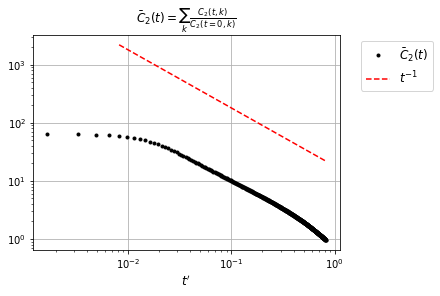

In [14]:
#time correlation in a single point in physical space - sum over k
one_point_corr = np.sum(correlation_mean*normalization,axis=1)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(t/t0, one_point_corr, 'k.',label=r'$\bar{C}_2 (t)$')
plt.plot(t[5:]/t0, 110*np.power(t[5:], -1.0), 'r--', label=r'$t^{-1}$')
ax.set(xscale='log', yscale='log', xlabel=r'$t^\prime$',title=r'$\bar{C}_2 (t) = \sum_k \frac{C_2(t, k)}{C_2(t=0, k)} $')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# FFT in time of correlation C_2(t,k)

## Compute and plot FFT

In [15]:
delta = t[1]-t[0]
omega = np.fft.fftfreq(t_length, delta)*2.0*np.pi
spectrum_of_correlation = np.ndarray(shape=(t_length, wavenumbers_length), dtype=complex)
for ik in list(range(wavenumbers_length)) :
    yf = np.fft.fft(correlation_mean[:,ik])
    spectrum_of_correlation[:, ik] = 1.0/t_length * yf

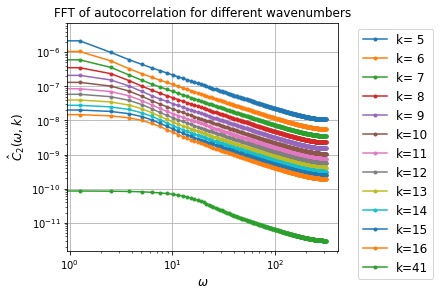

In [16]:
#plot \hat{C}_2(w, k) = FFT [C_2(t, k)]
fig, ax = plt.subplots(constrained_layout=True)
for ik in indices_of_k_to_plot :
    ax.plot(omega[0:t_length//2], np.absolute(spectrum_of_correlation[0:t_length//2, ik]), '.-', label='k=%2.f' % (k[ik]))
    #plt.plot(nu, 1.0/N * np.imag(yplot[:, ik]), label='k=%2.f' % k[ik])
#plt.xlim(-15, 15) 
#plt.plot(omega[1:t_length//2], 10e-6*omega[1:t_length//2]**(-1), 'k-', label=r'$\omega^{-1}$')
ax.set(xscale='log', yscale='log', xlabel=r'$\omega$', ylabel=r'$\hat{C}_2 (\omega, k)$', title='FFT of autocorrelation for different wavenumbers')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

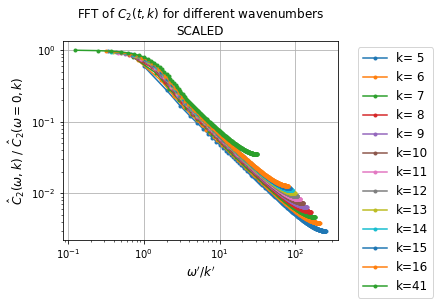

In [17]:
#plot SCALED \hat{C}_2(w, k) = FFT [C_2(t, k)]
fig, ax = plt.subplots(constrained_layout=True)
for ik in indices_of_k_to_plot :
    vertical_scale = 1.0/np.absolute(spectrum_of_correlation[0, ik])
    ax.plot(omega[1:t_length//2]*(t0)/(k[ik]*L), np.absolute(spectrum_of_correlation[1:t_length//2, ik])*vertical_scale, '.-', label='k=%2.f' % (k[ik]))
ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime / k^\prime$', ylabel=r'$\hat{C}_2 (\omega, k) \ / \ \hat{C}_2 (\omega=0, k)$', title="FFT of " r"$C_2(t,k)$" " for different wavenumbers" "\nSCALED")
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

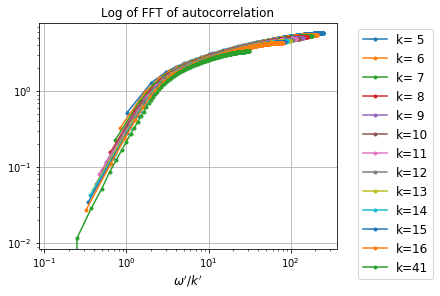

In [18]:
fig, ax = plt.subplots(constrained_layout=True)
for ik in indices_of_k_to_plot :
    spectrum = np.absolute(spectrum_of_correlation[:, ik])
    norm_coef = spectrum[0]
    horizontal_scale = 1.0/k[ik]
    #horizontal_scale = 1.0
    ax.plot(omega[1:t_length//2]*(t0)/(k[ik]*L), -np.log(spectrum[1:t_length//2]/norm_coef), '.-', label='k=%2.f' % (k[ik]))
    #plt.plot(nu, 1.0/N * np.imag(yplot[:, ik]), label='k=%2.f' % k[ik])
#plt.xlim(-15, 15) 
#plt.plot(omega[1:t_length//2]*(t0)/(k[ik]*L), 1.0*np.power(omega[1:t_length//2]*(t0)/(k[ik]*L), 2.0), 'k--', label=r'$(\omega/k)^2$')
#plt.plot(omega[1:t_length//2]*horizontal_scale, 1.0*np.power(omega[1:t_length//2]*horizontal_scale, 1.0/3.0), 'k-.', label=r'$(\omega/k)^{1/3}$')
ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime / k^\prime$',title='Log of FFT of autocorrelation')
#ax.set(ylim=[5e-2, 10e0])
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Total time spectrum (sum over all k) + characteristic freq scales

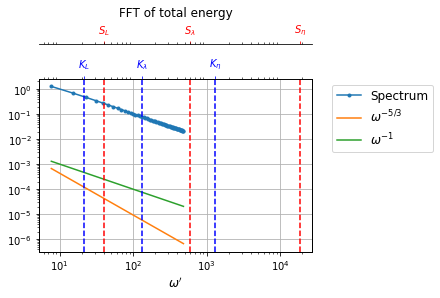

In [19]:
vertical_lines_kolmogorov = 2.0*np.pi*(wn_scales*L)**(2.0/3.0)
vertical_lines_sweeping = 2.0*np.pi*(wn_scales*L)

fig, ax = plt.subplots(constrained_layout=True)
total_energy_spectrum = np.zeros(shape=spectrum_of_correlation.shape[0], dtype=float)
range_of_k = list(range(wavenumbers_length))
for ik in range_of_k : 
    spectrum = np.absolute(spectrum_of_correlation[:, ik])
    coefficient = 4.0*np.pi*k[ik]*k[ik]
    total_energy_spectrum = total_energy_spectrum + spectrum*coefficient
    #total_energy_spectrum = total_energy_spectrum + spectrum
total_energy_spectrum = total_energy_spectrum/len(range_of_k)
total_energy_spectrum = total_energy_spectrum*1.0e4
ax.plot(omega[1:N//2]*t0, total_energy_spectrum[1:N//2], '.-', label='Spectrum')
ax.plot(omega[1:N//2]*t0, 2.0e-2*(omega[1:N//2]*t0)**(-5.0/3.0),label=r'$\omega^{-5/3}$')
ax.plot(omega[1:N//2]*t0, 10e-3*(omega[1:N//2]*t0)**(-1.0), label=r'$\omega^{-1}$')
for line in vertical_lines_kolmogorov : ax.axvline(x=line, c='blue', ls='--') #ax2
for line in vertical_lines_sweeping : ax.axvline(x=line, c='red', ls='--') #ax3
ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime$', title='FFT of total energy'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines_kolmogorov); ax2.set_xticklabels([r'$K_L$', r'$K_\lambda$', r'$K_\eta$'])
ax2.tick_params(axis='x', colors='blue')

ax3 = ax.twiny()
ax3.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax3.spines["top"].set_position(("axes", 1.2))
ax3.set_xticks(vertical_lines_sweeping); ax3.set_xticklabels([r'$S_L$', r'$S_\lambda$', r'$S_\eta$'])
ax3.tick_params(axis='x', colors='red')

plt.show()

In [20]:
# check the slope of the spectrum
# resampling = 1
# x = np.log(omega[1:N//2:resampling])
# f = np.log(total_energy_spectrum[1:N//2:resampling])
# slope = np.gradient(f, x)
# vertical_lines=np.log(vertical_lines_kolmogorov)
# for line in vertical_lines : plt.axvline(x=line)
# plt.plot(x[:-2:], slope[:-2:], '.-', label='Spectrum slope')
# plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-',label=r'$\omega^{-1}$')
# plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-', label=r'$\omega^{-5/3}$')
# plt.xlabel(r'$ln \omega^\prime$'), plt.ylabel('slope')
# plt.title('Slope of the spectrum in log-log scale')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xscale('linear')
# plt.grid()
# plt.show()

# Correlation fit

In [21]:
# Define the functions to fit

def gaussian(x, a, b):   
    return a * np.exp(-b * x**2) 
gaussian_nb_of_params = 2

# exponential
def exponent_function(x, a, b, c):   
    return a * np.exp(-b * x) + c
exponent_nb_of_params = 3

# exponential
def exponent_function2(x, a, b, c):   
    return a * np.exp(-b * x) 
exponent2_nb_of_params = 2

### Short times - Gaussian

In [22]:
tk1_gauss = 0.0
tk2_gauss = 2.0

optim_coef1 = np.ndarray(shape=(wavenumbers_length, gaussian_nb_of_params), dtype=float)
cov_matrix1 = np.ndarray(shape=(wavenumbers_length, gaussian_nb_of_params, gaussian_nb_of_params), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(t*k[ik]/t0*L, tk1_gauss)
    b = np.searchsorted(t*k[ik]/t0*L, tk2_gauss)
    xdata = t[a:b]*k[ik]/t0*L   # t'k' variable
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    ydata = correlation_mean[a:b, ik]*normalization[ik]
    try :
        optim_coef1[ik, :], cov_matrix1[ik, :, :] = curve_fit(gaussian, xdata, ydata)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef1[ik,:].fill(np.nan)
        continue

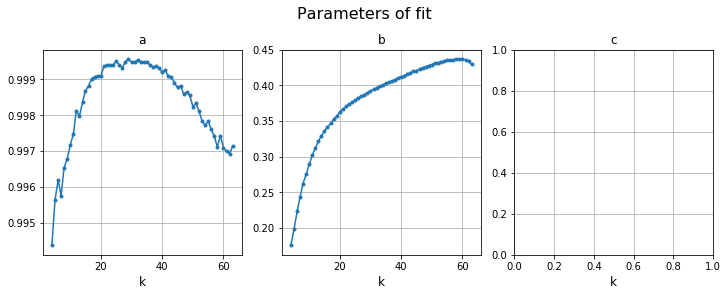

In [23]:
# plot fitting coeffiecients
ik1 = 3; ik2 = wavenumbers_length-1

fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ax_a.plot(k[ik1:ik2], optim_coef1[ik1:ik2, 0], '.-')
ax_b.plot(k[ik1:ik2], optim_coef1[ik1:ik2, 1], '.-')
#ax_c.plot(k[ik1:ik2]/k_norm_coef, optim_coef1[ik1:ik2, 2], '.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

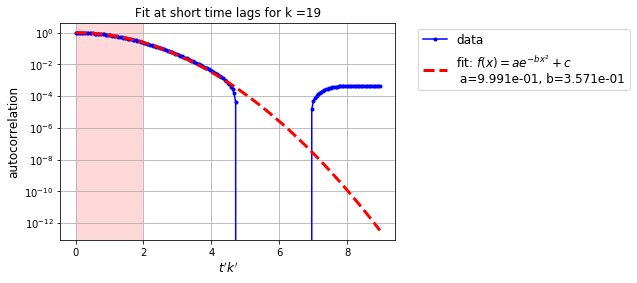

In [24]:
# Example of the gaussian fit for one wavenumber
ik = 18
a = np.searchsorted(t*k[ik]/t0*L, tk1_gauss)
b = np.searchsorted(t*k[ik]/t0*L, tk2_gauss+7)
coef_vector = optim_coef1[ik,:]
plt.plot(t[a:b]*k[ik]/t0*L, correlation_mean[a:b, ik]*normalization[ik], 'b.-', label='data')
plt.plot(t[a:b]*k[ik]/t0*L, gaussian(t[a:b]*k[ik]/t0*L, *coef_vector), 'r--', linewidth=3, label=r'fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e' % tuple(coef_vector))
plt.xlabel(r'$t^\prime k^\prime$'); plt.ylabel('autocorrelation'); plt.grid()
plt.axvspan(tk1_gauss, tk2_gauss, facecolor='red', alpha=0.15)
plt.title('Fit at short time lags for k =%2.f' % (k[ik]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale("log")
plt.show()

### Long time lags

In [25]:
# fitting range : 
tk1_long = 2.0
tk2_long = 5.0

optim_coef2 = np.ndarray(shape=(wavenumbers_length, 3), dtype=float)
cov_matrix2 = np.ndarray(shape=(wavenumbers_length, 3, 3), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(t*k[ik]/t0*L, tk1_long)
    b = np.searchsorted(t*k[ik]/t0*L, tk2_long)
    xdata = t[a:b]*k[ik]/t0*L
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    ydata = correlation_mean[a:b, ik]*normalization[ik]
    try :
        optim_coef2[ik, :], cov_matrix2[ik,:,:] = curve_fit(exponent_function, xdata, ydata)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef2[ik,:].fill(np.nan)
        continue
    max_param_std = 100
    if (np.count_nonzero(np.sqrt(np.diag(cov_matrix2[ik,:,:])>max_param_std)) > 0) :
        print('point out ik = ', ik)
        cov_matrix2[ik,:,:].fill(np.nan)
        optim_coef2[ik,:].fill(np.nan)

Failed optimization for ik =  0


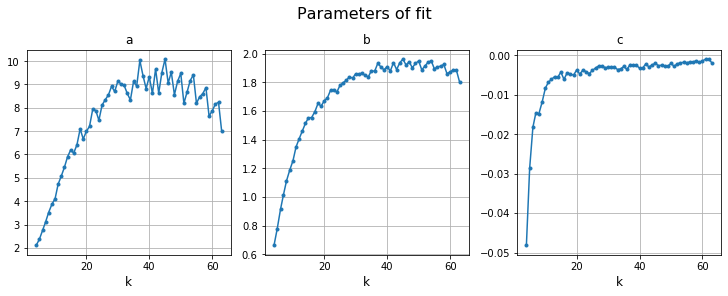

In [26]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ik1 = 3; ik2 = wavenumbers_length-1
ax_a.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 0],'.-')
ax_b.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 1],'.-')
ax_c.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 2],'.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

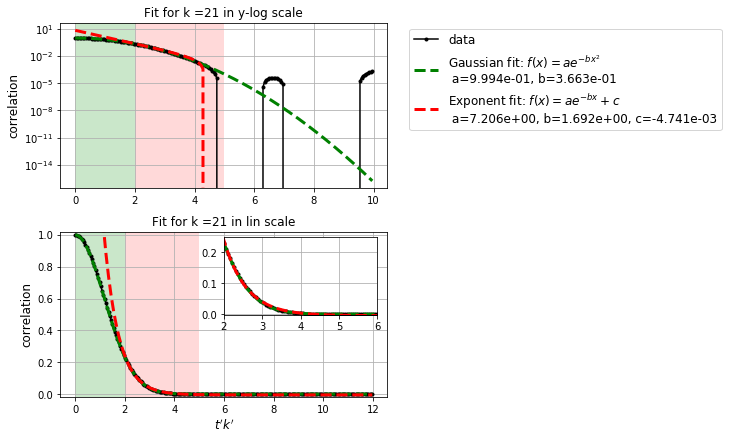

In [27]:
# Example of the exponential fit for one wavenumber
ik = 20
a = np.searchsorted(t*k[ik]/t0*L, 0)
b = np.searchsorted(t*k[ik]/t0*L, tk1_long+8)
coef_vector = optim_coef2[ik,:]

fig, (ax_log, ax_lin) = plt.subplots(nrows=2, ncols=1, figsize=(10,6), constrained_layout=True)
x = t[a:b]*k[ik]/t0*L
ax_log.plot(x, correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
ax_log.plot(x, gaussian(x, *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2}$' + "\n" + ' a=%5.3e, b=%5.3e' % tuple(optim_coef1[ik,:]))
ax_log.plot(x, exponent_function(x, *optim_coef2[ik,:]), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef2[ik,:]))
ax_log.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_log.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_log.set( yscale="log", ylabel='correlation', title='Fit for k =%2.f' % (k[ik]) +' in y-log scale'); ax_log.grid()
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

a = np.searchsorted(t*k[ik]/t0*L, 0)
b = np.searchsorted(t*k[ik]/t0*L, tk1_long+10)
x = t[a:b]*k[ik]/t0*L
ax_lin.plot(x, correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
ax_lin.plot(x, gaussian(x, *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2}$' + "\n" + ' a=%5.3e, b=%5.3e' % tuple(optim_coef1[ik,:]))
ax_lin.plot(x, exponent_function(x, *optim_coef2[ik,:]), 'r--', linewidth=3)
ax_lin.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_lin.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_lin.set(ylim=(-0.02,1.02), xlabel=r'$t^\prime k^\prime$', ylabel='correlation',title='Fit for k =%2.f' % (k[ik]) +' in lin scale'); ax_lin.grid()

zoom = ax_lin.inset_axes([0.5, 0.5, 0.47, 0.47])
zoom.plot(x, correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
zoom.plot(x, gaussian(x, *optim_coef1[ik,:]), 'g--', linewidth=3)
zoom.plot(x, exponent_function(x, *optim_coef2[ik,:]), 'r--', linewidth=3)
#zoom.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
#zoom.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
zoom.set(ylim=(-0.001,0.25), xlim=(2.0,6.0), yscale="linear"); zoom.grid()
plt.show()